In [1]:
import pandas as pd
import yaml
import random
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import LayerNormalization,BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout
from tensorflow.keras.models import model_from_yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

np.set_printoptions(suppress=True)

In [2]:
def readFile(filePath):
    lemma_result = pd.read_csv(filePath)
    print(lemma_result.shape)
    return lemma_result

In [3]:
def checkLength(max_feat, file):
    leng = 0
    sentence = []
    allData = file['cleaned_review']

    max_fatures = max_feat
    tokenizer = Tokenizer(num_words=max_fatures, split=' ') 
    tokenizer.fit_on_texts(allData.values)
    X1 = tokenizer.texts_to_sequences(allData.values)
    
    for i in X1:
        if len(i)>leng:
            leng = len(i)
            sentence = i
    print(leng)
    print(sentence)
    return leng

In [4]:
def beforeCreateModel(max_feat,dataset,max_length):
    max_fatures = max_feat #จำนวนคำที่ใช้ใน model
    tokenizer = Tokenizer(num_words=max_fatures, split=' ') 
    tokenizer.fit_on_texts(dataset['cleaned_review'].values)
    X1 = tokenizer.texts_to_sequences(dataset['cleaned_review'].values)
    print(len(tokenizer.word_index))
    feat = pad_sequences(X1, padding='pre',maxlen=max_length) # 505 = max_length in sentence
    target = dataset['Label'].values

    return feat,target,tokenizer

In [5]:
def createModelLSTM(embed_dim,lstm_out,max_feat,input_length): #(MAX_FEAT=5000)
    embed_dim = embed_dim
    lstm_out = lstm_out
    model = Sequential() #Create Model
    model.add(Embedding(input_dim = max_feat ,output_dim = embed_dim ,input_length = input_length)) #Input Layer
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)) #1st Hidden Layer
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu')) #2nd Hidden Layer
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='relu')) #3rd Hidden Layer
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid')) # Output Layer
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

In [6]:
def createModelGRU(embed_dim,gru_out,max_feat,input_length):
    embed_dim = embed_dim
    gru_out = gru_out
    model = Sequential()
    model.add(Embedding(max_feat, embed_dim,input_length = input_length)) 
    model.add(Dropout(0.2))
    model.add(GRU(gru_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

In [7]:
def trainModel(model,feat,target,validation_split,epochs,batch_size):
    random.seed(10)
    history = model.fit(feat, target,validation_split=validation_split, epochs = epochs, batch_size=batch_size)
    return history

In [8]:
def evaluateModel(model,feat,target,batch_size):
    score,acc = model.evaluate(feat, target, verbose = 2, batch_size = batch_size)
    print("score: %.2f" % (score))
    print("acc: %.2f" % (acc))

In [28]:
def plotLoss(history):
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(loss_values)+1)

    plt.plot(epochs, loss_values, label='Training Loss')
    plt.plot(epochs, val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
def saveModel(model):
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open("addTestTrainSize.yaml", "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5
    model.save_weights("addTestTrainSize.h5")
    print("Saved model to disk")

In [11]:
def loadModel(yamlPathName, h5PathName):
    with open(yamlPathName+'.yaml', 'r') as yaml_file:
        print(yamlPathName)
        loaded_model_yaml = yaml_file.read()
        loaded_model = model_from_yaml(loaded_model_yaml)
        loaded_model.load_weights(h5PathName+'.h5')
    loaded_model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return loaded_model

In [12]:
def filterAndShow(filter1, filter2, modelOutput, labelTest):
    print(modelOutput)
    test = []
    test_y = []

    for i in range(len(modelOutput)):
        if(modelOutput[i] <filter1 or modelOutput[i]>filter2):
            test.append(modelOutput[i])
            test_y.append(labelTest[i])

    test1 = np.array(test)
    testy1 = np.array(test_y)
    print(testy1)
    print(test1.shape)
    print(testy1.shape)
    showConfusionMatrix(testy1, test1)

In [13]:
def showConfusionMatrix(trueLabel,resultToShow):
    labels = ['positive','negative']
    cm = confusion_matrix(y_true=trueLabel , y_pred=resultToShow>0.5)
    print(cm)

In [14]:
def showWordWithCode(dataToMap, tokenizer): #dataToMap = list of sentiment
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items())) # map id to all word in dic
    
    def sequence_to_text(list_of_indices):
        # Looking up words in dictionary
        words = [reverse_word_map.get(letter) for letter in list_of_indices]
        return(words)
    
    my_texts = list(map(sequence_to_text, dataToMap))
    my_texts
    return my_texts

In [15]:
def saveSentimentAndResult(sentenceToSave, resultToSave):
    sen_temp = ""
    SentimentSave = []
    for one_sentence in sentenceToSave:
        for word in one_sentence:
            if isinstance(word, str):
                sen_temp = sen_temp + " " + word
            
        SentimentSave.append(sen_temp)
        sen_temp = ""
            
    #make 1 Dim predict result
    resultSave = []
    for arr_result in resultToSave:
        for result in arr_result:
            #print(result)
            resultSave.append(result)
            
    data = {'lemma_review': SentimentSave, 'predict score': resultSave}
    toFile = pd.DataFrame(data)
    toFile.to_csv("./for_compare.csv", index=False)

Test

In [16]:
MAX_FEATURE = 5000

In [17]:
path = "../Clean/lemma_result.csv"
x = readFile(path)

(1000, 2)


In [18]:
max_length = checkLength(MAX_FEATURE,x)

565
[14, 1939, 656, 49, 156, 68, 128, 36, 37, 183, 1939, 424, 4164, 4722, 1929, 42, 1145, 46, 6, 1939, 49, 3410, 38, 751, 183, 797, 193, 30, 396, 2, 1547, 6, 2007, 873, 55, 66, 29, 14, 780, 327, 12, 1939, 158, 4436, 232, 59, 19, 751, 2344, 889, 2, 29, 46, 6, 120, 183, 267, 133, 24, 1939, 1, 44, 730, 2887, 3476, 133, 556, 1733, 1, 118, 221, 42, 779, 133, 3127, 226, 302, 4370, 4371, 226, 968, 300, 3083, 2334, 916, 1940, 3626, 2722, 15, 6, 133, 155, 178, 89, 222, 26, 328, 4370, 4371, 226, 699, 41, 226, 41, 226, 7, 330, 99, 4370, 4371, 4, 1478, 3591, 2512, 4, 1557, 11, 1, 68, 128, 99, 4, 140, 13, 223, 1546, 2, 10, 391, 37, 4370, 4371, 140, 746, 1939, 1233, 11, 226, 164, 19, 14, 4088, 42, 99, 6, 3127, 226, 173, 1018, 2, 521, 5, 226, 277, 4, 2, 631, 12, 81, 420, 843, 631, 2, 20, 902, 12, 81, 113, 27, 81, 226, 2, 15, 740, 1784, 1172, 1079, 91, 1300, 89, 24, 6, 3127, 268, 18, 1503, 2180, 3626, 2722, 873, 4973, 4078, 64, 364, 42, 424, 64, 364, 49, 1929, 4973, 4078, 268, 776, 3127, 91, 133, 155,

In [19]:
feat,target,tokenizer = beforeCreateModel(max_feat=MAX_FEATURE,dataset=x,max_length=max_length)

feat,target

14771


(array([[   0,    0,    0, ...,  406, 3108,  310],
        [   0,    0,    0, ..., 2704,   18,  121],
        [   0,    0,    0, ...,   10,    5,  332],
        ...,
        [   0,    0,    0, ...,    4,  645,  771],
        [   0,    0,    0, ...,  964,  606,    1],
        [   0,    0,    0, ...,   57,  101, 1004]]),
 array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 0,

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(feat,target, test_size = 0.2, train_size = 0.8, random_state = 42)

LSTM

In [22]:
model = createModelLSTM(embed_dim=16,lstm_out=16,max_feat=MAX_FEATURE,input_length=feat.shape[1])
print("Input Shape is " + str(feat.shape[1]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 565, 16)           80000     
_________________________________________________________________
dropout (Dropout)            (None, 565, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [23]:
history = trainModel(model,feat=X_train,target=Y_train,validation_split=0.2,epochs=15,batch_size=32)

Train on 640 samples, validate on 160 samples
Epoch 1/15
640/640 [==============================] - 22s 34ms/sample - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 2/15
640/640 [==============================] - 19s 29ms/sample - loss: 0.6929 - accuracy: 0.5094 - val_loss: 0.6930 - val_accuracy: 0.4938
Epoch 3/15
640/640 [==============================] - 20s 32ms/sample - loss: 0.6920 - accuracy: 0.5094 - val_loss: 0.6928 - val_accuracy: 0.4938
Epoch 4/15
640/640 [==============================] - 25s 39ms/sample - loss: 0.6906 - accuracy: 0.5094 - val_loss: 0.6913 - val_accuracy: 0.4938
Epoch 5/15
640/640 [==============================] - 20s 31ms/sample - loss: 0.6850 - accuracy: 0.5094 - val_loss: 0.6881 - val_accuracy: 0.4938
Epoch 6/15
640/640 [==============================] - 21s 32ms/sample - loss: 0.6678 - accuracy: 0.5094 - val_loss: 0.6713 - val_accuracy: 0.4938
Epoch 7/15
640/640 [==============================] - 20s 31ms/sample - loss: 

In [24]:
evaluateModel(model,feat=X_test,target=Y_test,batch_size=32)

200/200 - 1s - loss: 0.5833 - accuracy: 0.7450
score: 0.58
acc: 0.75


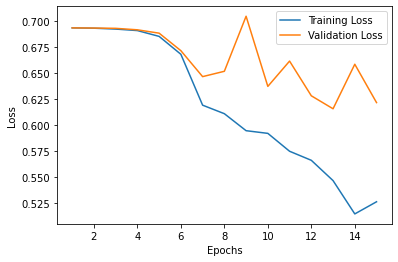

In [29]:
plotLoss(history=history)

In [ ]:
saveModel(model)

In [ ]:
test = loadModel('./11_Save_model_10000_data_LSTM/addTestTrainSize','./11_Save_model_10000_data_LSTM/addTestTrainSize')

In [30]:
test = model

In [31]:
result = test.predict(X_test)

In [32]:
filterAndShow(filter1=0.4, filter2=0.6, modelOutput=result, labelTest=Y_test) #LSTM with filter

[[0.5083181 ]
 [0.49038   ]
 [0.46402824]
 [0.46402824]
 [0.81438494]
 [0.87039334]
 [0.8349694 ]
 [0.6501633 ]
 [0.5169188 ]
 [0.46402824]
 [0.8556646 ]
 [0.7464039 ]
 [0.46402824]
 [0.7340115 ]
 [0.46402824]
 [0.48281658]
 [0.8665713 ]
 [0.570228  ]
 [0.6149864 ]
 [0.87296146]
 [0.8822025 ]
 [0.46402824]
 [0.5584957 ]
 [0.57480985]
 [0.46402824]
 [0.59751695]
 [0.46402824]
 [0.831289  ]
 [0.67663884]
 [0.67609423]
 [0.46402824]
 [0.46402824]
 [0.7070981 ]
 [0.86207855]
 [0.7301507 ]
 [0.8314441 ]
 [0.48840642]
 [0.7274402 ]
 [0.46402824]
 [0.8672262 ]
 [0.69629866]
 [0.46402824]
 [0.46402824]
 [0.46402824]
 [0.8465408 ]
 [0.83901054]
 [0.51993775]
 [0.73319   ]
 [0.7998896 ]
 [0.80771035]
 [0.73782   ]
 [0.46402824]
 [0.5167941 ]
 [0.46402824]
 [0.5367362 ]
 [0.82357645]
 [0.46402824]
 [0.48512772]
 [0.7804726 ]
 [0.7632955 ]
 [0.46402824]
 [0.63915133]
 [0.46402824]
 [0.61031306]
 [0.46402824]
 [0.49948865]
 [0.8448893 ]
 [0.8594726 ]
 [0.70690703]
 [0.46402824]
 [0.46402824]
 [0.87

In [33]:
showConfusionMatrix(trueLabel=Y_test,resultToShow=result) #LSTM no filter

[[58 46]
 [ 5 91]]


In [ ]:
confusion_matrix(y_true=Y_test, y_pred=result>0.5)

In [ ]:
hi=showWordWithCode(dataToMap=X_test, tokenizer=tokenizer)

In [ ]:
result

In [ ]:
hi

In [ ]:
saveSentimentAndResult(hi,result)

GRU

In [ ]:
model = createModelGRU(embed_dim=150,gru_out=200,max_feat=7000,input_length=feat.shape[1])

In [ ]:
trainModel(model,feat=X_train,target=Y_train,validation_split=0.2,epochs=50,batch_size=32)

In [ ]:
evaluateModel(model,feat=X_test,target=Y_test,batch_size=32)

In [ ]:
resultGRU = model.predict(X_test)

In [ ]:
filterAndShow(filter1=0.4, filter2=0.6, modelOutput=resultGRU, labelTest=Y_test) #GRU with filter

In [ ]:
showConfusionMatrix(trueLabel=Y_test,resultToShow=result) #GRU no filter

In [ ]:
saveModel(model)

Web Read

In [34]:
path = "../Clean/lemma_master_result.csv"
x = readFile(path)

x

(50, 2)


,cleaned_review,Label
0,mr costner drag movie far longer necessary asi...,0
1,example majority action film generic bore real...,0
2,first hate moronic rappers could nt act gun pr...,0
3,even beatles could write songs everyone like a...,0
4,brass picture movies fit word really somewhat ...,0
5,funny thing happen watch mosquito one hand her...,0
6,german horror film one weirdest see aware conn...,0
7,long time fan japanese film expect really both...,0
8,tokyo eye tell 17 year old japanese girl fall ...,0
9,wealthy horse ranchers buenos air long stand t...,0


In [ ]:
testWR = loadModel('./11_Save_model_10000_data_LSTM/addTestTrainSize','./11_Save_model_10000_data_LSTM/addTestTrainSize')

In [35]:
testWR = model

In [36]:
#x_cut = x[1001:1101]
featWR,targetWR,tokenizerr = beforeCreateModel(max_feat=MAX_FEATURE,dataset=x,max_length=max_length) #fulldic max_feat = 14000

featWR,targetWR

2334


(array([[   0,    0,    0, ...,  572,   81,  422],
        [   0,    0,    0, ...,   96,  250,  251],
        [   0,    0,    0, ...,   54,   97,  151],
        ...,
        [   0,    0,    0, ..., 2278,  130,    7],
        [   0,    0,    0, ...,  170, 2305, 2306],
        [   0,    0,    0, ..., 2333,  923, 2334]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int64))

In [ ]:
featWR.shape[1]

In [37]:
resultWR = testWR.predict(featWR)

resultWR

array([[0.7685063 ],
       [0.8304322 ],
       [0.8428893 ],
       [0.81368685],
       [0.83447164],
       [0.7088296 ],
       [0.5955077 ],
       [0.56339294],
       [0.84090984],
       [0.46402824],
       [0.46402824],
       [0.8377493 ],
       [0.81211114],
       [0.46402824],
       [0.5129277 ],
       [0.8244826 ],
       [0.8275987 ],
       [0.814948  ],
       [0.8254225 ],
       [0.74971926],
       [0.53957766],
       [0.58596873],
       [0.86203736],
       [0.82516587],
       [0.8083075 ],
       [0.7218778 ],
       [0.8441299 ],
       [0.84368426],
       [0.8347589 ],
       [0.72843236],
       [0.82708555],
       [0.701409  ],
       [0.5910873 ],
       [0.53382784],
       [0.69760424],
       [0.8411495 ],
       [0.80341053],
       [0.46402824],
       [0.76934993],
       [0.7982026 ],
       [0.6348549 ],
       [0.78219706],
       [0.63651806],
       [0.6664623 ],
       [0.81860006],
       [0.46402824],
       [0.772253  ],
       [0.464

In [38]:
showConfusionMatrix(trueLabel=targetWR,resultToShow=resultWR)
#confusion_matrix(target[:,1] , result>0.5)

[[ 6 44]
 [ 0  0]]


In [ ]:
showWordWithCode(dataToMap=featWR , tokenizer=tokenizerr)

In [ ]:
evaluateModel(testWR,feat=X_test,target=Y_test,batch_size=32)

In [ ]:
testWR.summary()